In [1]:
!pip install tensorflow_addons
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten, Add, Conv1D, Layer
from tensorflow.keras.optimizers import RMSprop, Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tensorflow_addons.metrics import F1Score
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

from transformers import AutoTokenizer, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from tensorflow.nn import softmax as tf_softmax
import nltk
from nltk.stem import WordNetLemmatizer 
%matplotlib inline
import nltk
from transformers import RobertaTokenizer, RobertaModel




/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive: ', is_interactive())

Interactive:  True


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


## **DATA LOADING AND PREPROCESSING**

In [5]:
df = pd.read_csv('/content/train_all_tasks.csv',delimiter=',',encoding='utf-8')
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [6]:
# df['text'] = df['text'].map(lambda sentence:lemmatize(sentence))
# df.head()

In [7]:
df.drop(['rewire_id'],axis=1,inplace=True)
df.head()

,text,label_sexist,label_category,label_vector
0,"Damn, this writing was pretty chaotic",not sexist,none,none
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,Understand. Know you're right. At same time I ...,not sexist,none,none
4,Surprized they didn't stop and rape some women,not sexist,none,none


In [8]:
task = 'a' # a,b,c
keys_for_task = {'a':'label_sexist','b':'label_category','c':'label_vector'}
key_for_task = keys_for_task[task]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            14000 non-null  object
 1   label_sexist    14000 non-null  object
 2   label_category  14000 non-null  object
 3   label_vector    14000 non-null  object
dtypes: object(4)
memory usage: 437.6+ KB
None


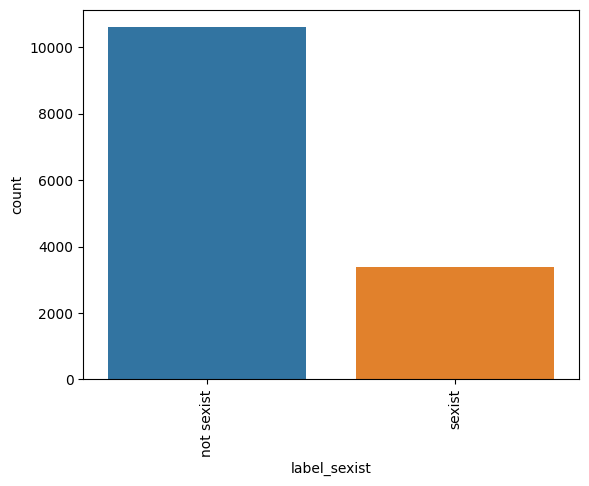

In [9]:
def count_plot(df, name, key_count = key_for_task):
    print(df.info())
    sn.countplot(data=df, x=key_count)
    plt.xticks(rotation = 90)
    plt.savefig(name)
    plt.show()
    
count_plot(df,"distribution.svg")

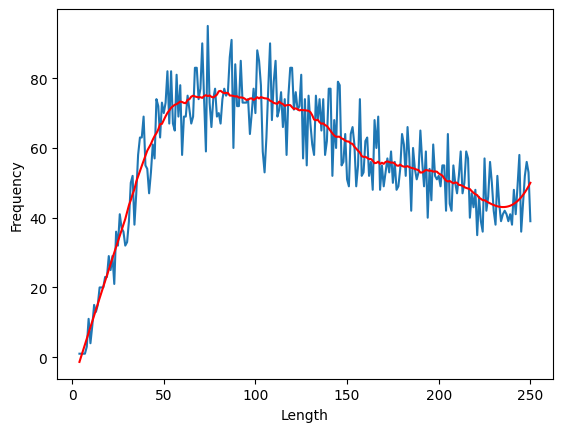

In [10]:
lens = df.text.str.len().value_counts()
count_plot = pd.DataFrame({'leng':lens.index, 'freq':lens.values}).sort_values('leng')
plt.plot(count_plot.leng,count_plot.freq)
plt.plot(count_plot.leng,savgol_filter(count_plot.freq, 51, 3), color='red')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# **LABEL ENCODING**

In [11]:
label_encoder = LabelEncoder()

# label encoding

X = df['text']
Y = df[key_for_task]
Y = label_encoder.fit_transform(Y)

In [12]:
label_encoder_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_encoder_mapping)

NUM_CLASS = len(label_encoder_mapping)

{'not sexist': 0, 'sexist': 1}


In [13]:
# one hot encoding

Y = tf.keras.utils.to_categorical(Y, num_classes=NUM_CLASS)

In [14]:
DEBUG_EPOCH = 15 # keep it 2, just to test notebook, before saving

EPOCH = DEBUG_EPOCH if is_interactive() else 180
print(EPOCH)

LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2

15


# **SPLIT AND REGULARIZATION**

In [15]:
SHUFFLE_DS = 1024
BATCH_SIZE_DS = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

if task == 'a':
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3, stratify=Y)
else:
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3)
    
N_STEPS = len(train_X) / BATCH_SIZE_DS

In [16]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10)
early_stopping_callback = EarlyStopping(monitor='val_loss',min_delta=0,patience=30,verbose=0, mode='auto')
model_saver = ModelCheckpoint(filepath='model.h5', save_best_only=True)

callbacks = [early_stopping_callback, lr_reducer,model_saver]

# **SENTENCE TRANSFORMATION**

In [17]:
# "sentence-transformers/all-MiniLM-L6-v2"
## https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

class Sentence2Sentence(Layer):
    def __init__(self, **kwargs):
        super(Sentence2Sentence, self).__init__(**kwargs)

        pre_name = "sentence-transformers/all-MiniLM-L6-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(pre_name)
        self.model = TFAutoModel.from_pretrained(pre_name)

        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode('utf-8') for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return (outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask'])

        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])

    def process(self,i,t,a):

        def __call(i, t, a):
            model_output = self.model({'input_ids': i.numpy(),'token_type_ids': t.numpy(),'attention_mask': a.numpy()})
            return model_output[0]

        return tf.py_function(func=__call, inp=[i, t, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1),tf.shape(token_embeddings)), tf.float32)
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        (embeddings, _) = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        (input_ids, token_type_ids, attention_mask) = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        token_type_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids, token_type_ids,attention_mask)
        
        model_output[0].set_shape(tf.TensorShape((None, None, 384)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings

# **MODEL ARCHITECHTURE**

In [18]:
from transformers import RobertaTokenizer, TFRobertaModel

class RobertaDistil(Layer):
    def __init__(self, **kwargs):
        super(RobertaDistil, self).__init__(**kwargs)

        pre_name = "roberta-base"
        self.tokenizer = RobertaTokenizer.from_pretrained(pre_name)
        self.model = TFRobertaModel.from_pretrained(pre_name)

        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode('utf-8') for x in inputs.numpy()]
            outputs = self.tokenizer.batch_encode_plus(inputs, padding=True, truncation=True, return_tensors='tf')
            return (outputs['input_ids'], outputs['attention_mask'])

        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32])

    def process(self,i,a):

        def __call(i, a):
            model_output = self.model({'input_ids': i.numpy(), 'attention_mask': a.numpy()})
            return model_output[0]

        return tf.py_function(func=__call, inp=[i, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1),tf.shape(token_embeddings)), tf.float32)
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        (embeddings, _) = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        (input_ids, attention_mask) = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids,attention_mask)
        
        model_output[0].set_shape(tf.TensorShape((None, None, 768)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings 


In [19]:
class StringLowerLayer(Layer):
    def __init__(self, **kwargs):
        super(StringLowerLayer, self).__init__(**kwargs)
        
    def call(self, inputs):
        return tf.strings.lower(inputs)

In [20]:
class StressLayer(Layer):
    def __init__(self, **kwargs):
        super(StressLayer, self).__init__(**kwargs)

In [21]:
def get_model():
    text_input = Input(shape=(1,), dtype=tf.string,)

    x = Sentence2Sentence()(text_input)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(NUM_CLASS, activation='sigmoid')(x)

    y = RobertaDistil()(text_input)
    y = Dropout(0.5)(y)
    y = Dense(512, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(256, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(64, activation='relu')(y)
    y = Dense(NUM_CLASS, activation='sigmoid')(y)

    x = Add()([x, y])

    model = Model(inputs=[text_input], outputs=[x])
    return model


In [22]:
with strategy.scope():
    model = get_model()
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(
        loss=CategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[
            'accuracy',
            F1Score(num_classes=NUM_CLASS,average='weighted'),
        ],
    )

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at robe

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 roberta_distil (RobertaDistil)  (None, 768)         124645632   ['input_1[0][0]']                
                                                                                                  
 dropout_58 (Dropout)           (None, 768)          0           ['roberta_distil[0][0]']         
                                                                                                  
 sentence2_sentence (Sentence2S  (None, 384)         22713216    ['input_1[0][0]']                
 entence)                                                                                     

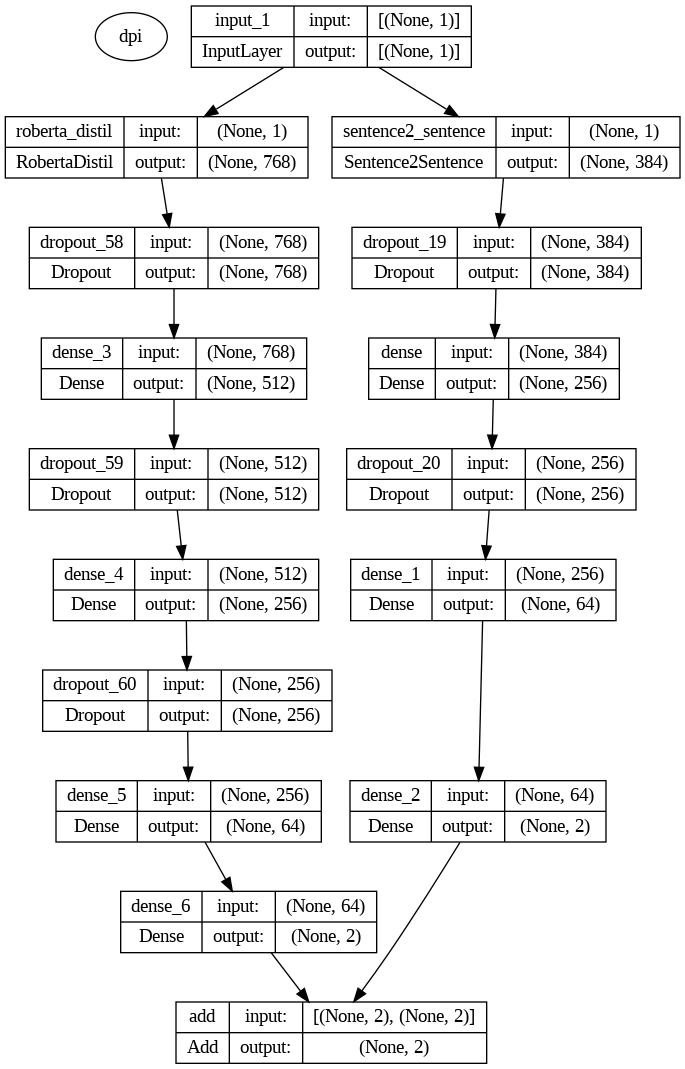

In [24]:
tf.keras.utils.plot_model(model, to_file='model.png',expand_nested=True,show_shapes=True,dpi=None,)

# **MODEL INFERENCE**

In [25]:
history_model = model.fit(train_X, train_Y,epochs=EPOCH,validation_data=(val_X, val_Y), callbacks=callbacks, steps_per_epoch = N_STEPS)

Epoch 1/15


612/612 [==============================] - 369s 589ms/step - loss: 0.5924 - accuracy: 0.7495 - f1_score: 0.6540 - val_loss: 0.5531 - val_accuracy: 0.7574 - val_f1_score: 0.6528 - lr: 5.0000e-05
Epoch 2/15
612/612 [==============================] - 315s 514ms/step - loss: 0.5495 - accuracy: 0.7572 - f1_score: 0.6526 - val_loss: 0.5438 - val_accuracy: 0.7574 - val_f1_score: 0.6528 - lr: 5.0000e-05
Epoch 3/15
612/612 [==============================] - 317s 518ms/step - loss: 0.5396 - accuracy: 0.7572 - f1_score: 0.6526 - val_loss: 0.5314 - val_accuracy: 0.7574 - val_f1_score: 0.6528 - lr: 5.0000e-05
Epoch 4/15
612/612 [==============================] - 315s 514ms/step - loss: 0.5274 - accuracy: 0.7572 - f1_score: 0.6526 - val_loss: 0.5130 - val_accuracy: 0.7574 - val_f1_score: 0.6528 - lr: 5.0000e-05
Epoch 5/15
612/612 [==============================] - 313s 512ms/step - loss: 0.5103 - accuracy: 0.7574 - f1_score: 0.6531 - val_loss: 0.4951 - val_accuracy: 0.7586 - val_f1_score: 0.6569 - l

In [26]:
!mkdir history

In [27]:
with open('history/history.json','w') as f:
    f.write(str(history_model.history))

In [28]:
!mkdir figures

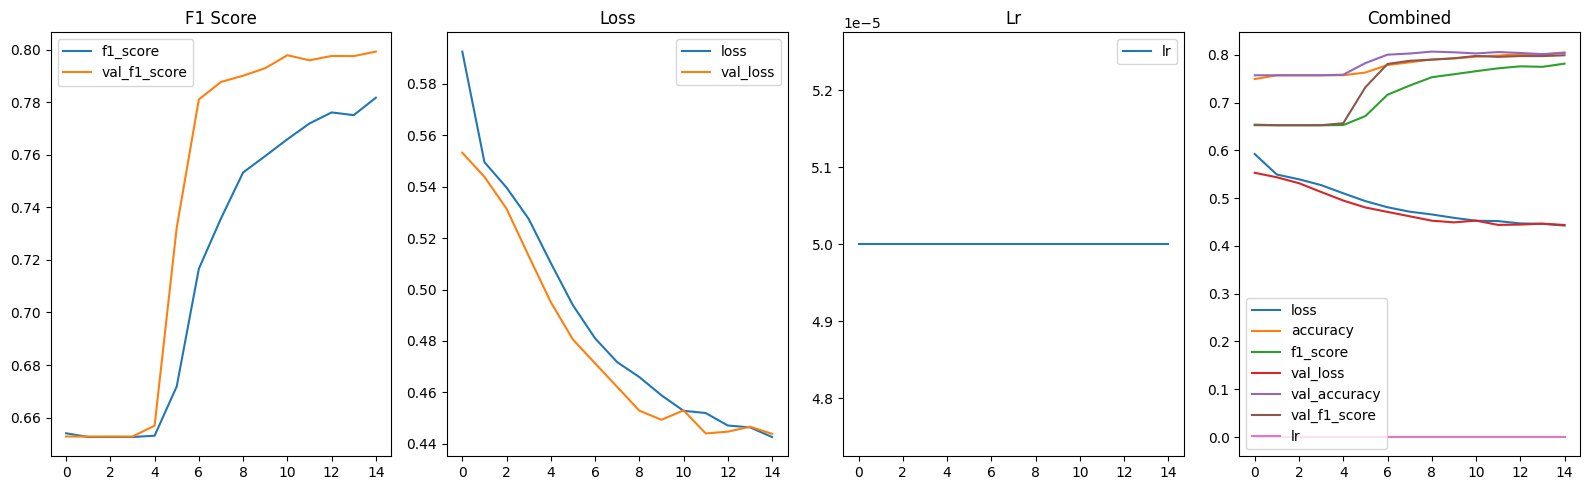

In [29]:
def captilize(string):
    string = string.replace("_"," ")
    return string.title()
    
    
def plot_graphs(data, keys):
    fig, axes = plt.subplots(1, (len(keys) + 1) , figsize=(16, 5))
    plt.legend(loc='best')
    
    for i in range(len(keys)):
        df_graph = pd.DataFrame({x:data[x] for x in data if keys[i] in x})
        df_keys = [x for x in data if keys[i] in x]
        df_graph[df_keys].plot(ax=axes[i])
        axes[i].set_title(captilize(keys[i]))
        
    last_index = len(keys)
    all_keys = [x for x in data if x]
    
    df_combined = pd.DataFrame({x: data[x] for x in data})
    df_combined[all_keys].plot(ax=axes[last_index])
    axes[len(keys)].set_title('Combined')
    
    plt.tight_layout()
    
    plt.savefig('figures/figure_optimizer.svg')
    plt.show()
        
plot_graphs(data = history_model.history, keys= ['f1_score','loss', 'lr'])